엔지니어는 절삭속도(A), 공구기하학(B), 절삭각(C)이 공구수명(시간당)에 미치는 효과에 대해 관심이 있다. 각 요소들은 두 개의 수준을 유지한다.

|A|B|C|처리조합|I|II|III|
|---|---|---|---|---|---|---|
|-|-|-|(1)|22|31|25|
|+|-|-|a|32|43|29|
|-|+|-|b|35|34|50|
|+|+|-|ab|55|47|46|
|-|-|+|c|44|45|38|
|+|-|+|ac|40|37|36|
|-|+|+|bc|60|50|54|
|+|+|+|abc|39|41|47|

# (a) 요인 효과 추정

설계행렬의 부호가 +인 것끼리 더하고 -인 것끼리 더해서 빼면 된다.

## 데이터프레임 설정

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

df = pd.DataFrame({
    'a': [-1, 1, -1, 1, -1, 1, -1, 1],
    'b': [-1, -1, 1, 1, -1, -1, 1, 1],
    'c': [-1,-1,-1,-1, 1, 1, 1, 1],
    '처리조합': ['(1)', 'a', 'b', 'ab', 'c', 'ac', 'bc', 'abc'],
    'I': [22, 32, 35, 55, 44, 40, 60, 39],
    'II': [31, 43, 34, 47, 45, 37, 50, 41],
    'III': [25, 29, 50, 46, 38, 36, 54, 47]
})

df

,a,b,c,처리조합,I,II,III
0,-1,-1,-1,(1),22,31,25
1,1,-1,-1,a,32,43,29
2,-1,1,-1,b,35,34,50
3,1,1,-1,ab,55,47,46
4,-1,-1,1,c,44,45,38
5,1,-1,1,ac,40,37,36
6,-1,1,1,bc,60,50,54
7,1,1,1,abc,39,41,47


## 효과 계산

In [2]:
from DOE import effect_est

for fac in df['처리조합']:
    if fac == '(1)':
        continue
    print(f'요인 {fac}의 효과:', effect_est(data=df, sign_col=[f for f in fac], value_cols=['I','II', 'III']))

요인 a의 효과: 0.3333333333333339
요인 b의 효과: 11.333333333333334
요인 ab의 효과: -1.6666666666666625
요인 c의 효과: 6.833333333333336
요인 ac의 효과: -8.833333333333334
요인 bc의 효과: -2.833333333333334
요인 abc의 효과: -2.166666666666666


절대값 기준 분석:
- b가 가장 강한 효과를 보임
- ac, c도 강한 효과
- bc도 유의한 효과가 있어 보임

# (b) 분산분석-유의수준 0.05

## 데이터프레임 형식 변경
_To long-format_

In [3]:
df_long = df.melt(id_vars=['a', 'b', 'c'], 
                  value_vars=['I', 'II', 'III'], 
                  var_name='Replication', 
                  value_name='Response')
df_long.head()

,a,b,c,Replication,Response
0,-1,-1,-1,I,22
1,1,-1,-1,I,32
2,-1,1,-1,I,35
3,1,1,-1,I,55
4,-1,-1,1,I,44


## 최소제곱법 응용 분산분석(설계행렬 기반)

In [4]:
model = sm.OLS.from_formula(formula='Response ~ a * b * c', data=df_long).fit()

sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
a,1.0,0.666667,0.666667,0.022099,0.883680
b,1.0,770.666667,770.666667,25.546961,0.000117
a:b,1.0,16.666667,16.666667,0.552486,0.468078
c,1.0,280.166667,280.166667,9.287293,0.007679
a:c,1.0,468.166667,468.166667,15.519337,0.001172
b:c,1.0,48.166667,48.166667,1.596685,0.224475
a:b:c,1.0,28.166667,28.166667,0.933702,0.348282
Residual,16.0,482.666667,30.166667,NaN,NaN


bc를 제외하면 전부 예상에 들어맞았다.

# (C) 회귀모형 작성

기본 분산분석 모형:

$$
Y = A_i + B_j + C_k + (AB)_{ij} + (AC)_{ik} + (BC)_{jk} + (ABC)_{ijk} + \epsilon_{ijk}
$$

$$
\begin{cases}
i = 1, 2\\ j=1,2\\k=1,2
\end{cases}
$$

In [5]:
model.summary(alpha=0.05) # 95% 신뢰구간 출력 옵션

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Response   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.669
Method:                 Least Squares   F-statistic:                     7.637
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           0.000398
Time:                        15:34:18   Log-Likelihood:                -70.070
No. Observations:                  24   AIC:                             156.1
Df Residuals:                      16   BIC:                             165.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     40.8333      1.121     36.421      0.000      38.457      43.210
a              0.1667      1.121      0.149      0.884      -2.210       2.543
b              5.6667      1.121      5.054      0.000       3.290       8.043
a:b           -0.8333      1.121     -0.743      0.468      -3.210       1.543
c              3.4167      1.121      3.048      0.008       1.040       5.793
a:c           -4.4167      1.121     -3.939      0.001      -6.793      -2.040
b:c           -1.4167      1.121     -1.264      0.224      -3.793       0.960
a:b:c         -1.0833      1.121     -0.966      0.348      -3.460       1.293
==============================================================================
Omnibus:                        2.520   Durbin-Watson:                   2.209
Prob(Omnibus):                  0.284   Jarque-Bera (JB):                2.170
Skew:                           0.671   Prob(JB):                        0.338
Kurtosis:                       2.391   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

적합된 회귀모형:

$$
y = 40.83 + + 5.67B + 3.42C - 4.42AC
$$

$40.83$은 전체 평균, 계수들은 평균 효과를 수준 개수 2로 나눈 것

# (d) 잔차분석

## 표준화 잔차 그림

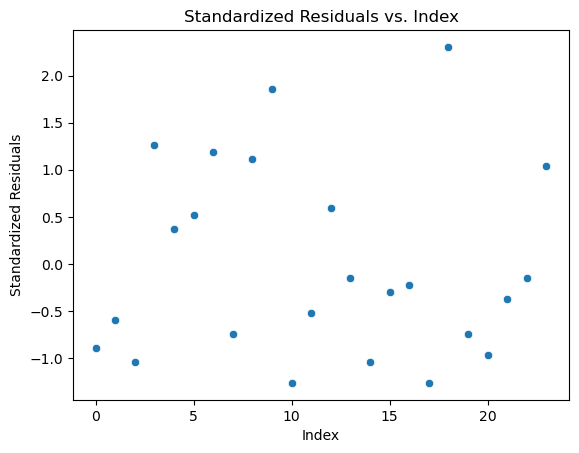

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=(model.resid - np.mean(model.resid)) / np.std(model.resid))
plt.xlabel('Index')
plt.ylabel('Standardized Residuals')
plt.title('Standardized Residuals vs. Index')
plt.show()

## 정규확률그림

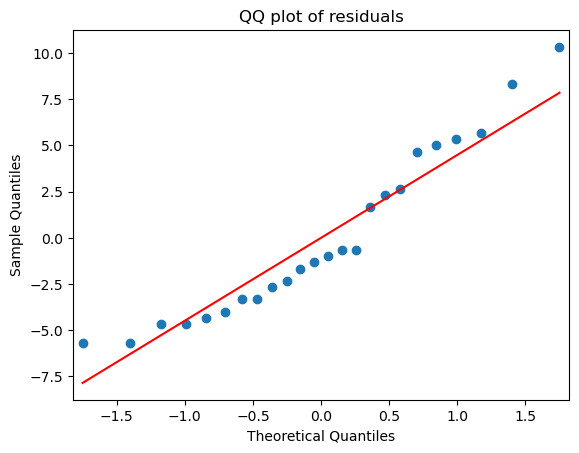

In [7]:
sm.qqplot(data=model.resid, line='s')
plt.title('QQ plot of residuals')
plt.show()

## 잔차 대 적합값 그림

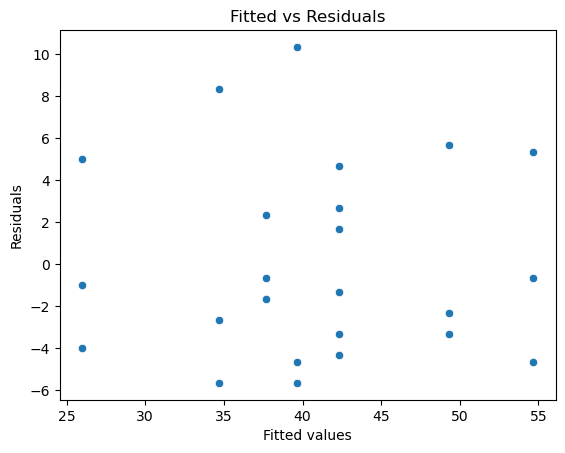

In [8]:
sns.scatterplot(x=model.fittedvalues, y=model.resid)
plt.title('Fitted vs Residuals')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

## ECDF vs. 정규난수

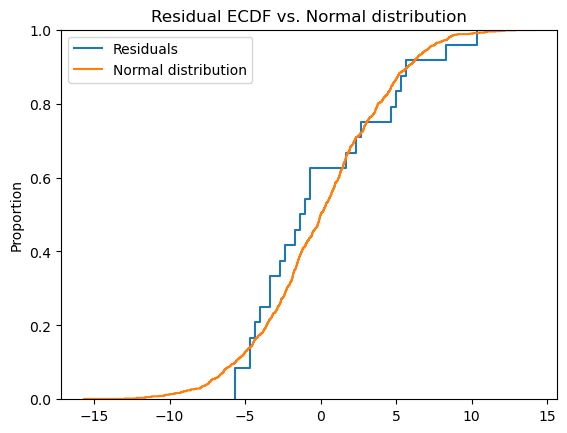

In [9]:
sns.ecdfplot(data=model.resid, label='Residuals')
sns.ecdfplot(data=np.random.normal(loc=np.mean(model.resid), scale=np.std(model.resid), size=1000), label='Normal distribution')
plt.title('Residual ECDF vs. Normal distribution')
plt.legend()
plt.show()

잔차는 정규성, 등분산성을 만족하는 것으로 보이나, 일부 데이터가 좀 멀리 떨어져 있긴 하다.